# Homework Assignment  5

**Question 1:** Select a directed network, and develop a simple
    link prediction classifier based on the network's directed topology (40pt). 
    Use node or link embedding features and try to improve the classification (20pt)
    
**Bonus:** Evaluate the classifier's ability to predict future links (10pt)
    
** Note:** You can use [Reddit community networks](http://dynamics.cs.washington.edu/data.html), or search
for networks using [The Colorado Index of Complex Networks](https://icon.colorado.edu/).

## Preperations: 
i chose to use the mouse_retina graphs from the Colorado Index of Comlex Networks as suggested, the graphs are available @ https://neurodata.io/project/connectomes/ under "#Mouse".

file:
mouse_retina_1 with #577350 edges and #1123 nodes @ https://s3.amazonaws.com/connectome-graphs/mouse/mouse_retina_1.graphml

nodes have the attributes:
name, designation, macneil_type, certainty, volgyi_type, coarse, y, x, z, id
edges have the attributes:
y, x, z, area

I chose not to use these attributes as most of them are with a majority of NA values, and the loci of each node/edge is an attribute that will provide "un-fair" knowledge to the algorithm for link prediction. 

In the chosen dataset there is no time related data, therefore i will not solve the bonus question.

In [ ]:
! mkdir ./datasets/miceRetina
! wget --directory-prefix ./datasets/miceRetina https://s3.amazonaws.com/connectome-graphs/mouse/mouse_retina_1.graphml
! pip install turicreate
! pip install tqdm
! pip install karateclub

mkdir: cannot create directory ‘./datasets/miceRetina’: No such file or directory
--2021-11-16 09:10:51--  https://s3.amazonaws.com/connectome-graphs/mouse/mouse_retina_1.graphml
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.12.254
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.12.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117057866 (112M) [application/x-www-form-urlencoded]
Saving to: ‘./datasets/miceRetina/mouse_retina_1.graphml’

mouse_retina_1.grap 100%[===================>] 111.63M  44.8MB/s    in 2.5s    

2021-11-16 09:10:54 (44.8 MB/s) - ‘./datasets/miceRetina/mouse_retina_1.graphml’ saved [117057866/117057866]

     |████████████████████████████████| 92.0 MB 4.4 kB/s 
     |████████████████████████████████| 86.4 MB 12 kB/s 
     |████████████████████████████████| 3.6 MB 43.6 MB/s 
     |████████████████████████████████| 322 kB 58.8 MB/s 
     |████████████████████████████████| 3.5 MB 33.9 MB/s 
     |██████████████████████

     |████████████████████████████████| 62 kB 559 kB/s 
     |████████████████████████████████| 1.8 MB 11.5 MB/s 
     |████████████████████████████████| 24.1 MB 1.7 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
  Created wheel for karateclub: filename=karateclub-1.2.2-py3-none-any.whl size=97744 sha256=854b6c87cd1e13a52ff320698aca9d427c75736bc138631e583de47120edffeb
  Stored in directory: /root/.cache/pip/wheels/14/4b/99/abc777e42da28bc43b6959267f4f1c5eee06814a5c608a9ed2
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149862 sha256=0fe7695b05a688326bbea88fa35d77a66402d461d45e926f493e56699e146cb2
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built karateclub python-Levenshtein
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
# IMPORTS:
import os
import numpy as np
from typing import *
import pandas as pd
import matplotlib.pyplot as plt
import turicreate as turi
import networkx as ntkx
from tqdm.notebook import tqdm 
import random 

%matplotlib inline

## Answer to Q1:

### Q1 part 1:

In [ ]:
# reading the graph using networkx due to its built in capability to read graphml files.
neurons_graph_ntkx = ntkx.read_graphml('/content/datasets/miceRetina/mouse_retina_1.graphml')
print(f'#Nodes: {len(neurons_graph_ntkx.nodes)}, #Edges: {len(neurons_graph_ntkx.edges)}, Is directed: {neurons_graph_ntkx.is_directed()}')

#Nodes: 1123, #Edges: 577350, Is directed: True


In [ ]:
# simple link prediction classifier based on the network's directed topology

friends_of_friends_memoization_dict = {}
# number of negative/positive links taken for the dataset of the training&testing of models 
# if you want to test execution without wasting time, we suggest to use a k_samples_num<=1000 value 
k_samples_num = 2000
# creating the link features sframe using the functions shown in class
def get_all_link_features_sframe(graph_to_analyze: ntkx.DiGraph, embeddings = None):
  # helper functions:
  def find_friends_of_friends(g, v):
      global friends_of_friends_memoization_dict
      if friends_of_friends_memoization_dict.get((g,v), None) is None:
          friends_set = set(g.neighbors(v))
          friends_of_friends_set = set()
          for f in friends_set:
              friends_of_friends_set |= set(g.neighbors(f))
          friends_of_friends_set -= friends_set
          friends_of_friends_set -= {v}
          friends_of_friends_memoization_dict[(g, v)] = friends_of_friends_set
          return friends_of_friends_set
      else:
          return friends_of_friends_memoization_dict.get((g,v))

  def common_friends(g,u,v):
      if not g.has_node(u) or not g.has_node(v):
          return None
      return set(g.neighbors(u)) & set(g.neighbors(v))

  def select_random_existing_links(g: ntkx.DiGraph, n):
      l =list(g.edges())
      random.shuffle(l)
      return l[:n]
  # here we decided to use the completely random non existing links method, and not the distance of 2 method.
  # this decision is based on the fact that neurons are very dense in connections/links, as evidence, see the number of nodes compared to the number of edges. 
  def select_random_non_existing_links(g: ntkx.DiGraph, n):
      select_links = set()
      v_list = list(g.nodes())
      while len(select_links) < n:
          u = random.choice(v_list)
          v = random.choice(v_list)
          if g.has_edge(u,v) or (u,v) in select_links and u == v:
              continue
          else:
              select_links.add((u,v))
      return list(select_links)

  def friends_measure(g, u,v):
      s = 0
      for x in find_friends_of_friends(g,u):
          for y in find_friends_of_friends(g,v):
              if g.has_edge(x,y) or x == y:
                  s += 1
      return s

  def total_friends(g, u, v):   
      return len(set(g.neighbors(v)) | set(g.neighbors(u)))

  def get_features_dict(g: ntkx.DiGraph,u, v, embeddings = None):
      removed_edge = False
      if g.has_edge(u,v):
          g.remove_edge(u,v) #  remove edge before feature calculation
          removed_edge = True
      try:
          d = {
              'degree_v': len(list(g.neighbors(v))),
              'degree_u': len(list(g.neighbors(u))),
              'total_friends': total_friends(g,u,v),
              'common_friends': len(common_friends(g,u,v)),
              'friends_measure': friends_measure(g, u,v)
          }
          if embeddings is not None:
              # u_idx, v_idx = node_to_numerical_dict[u], node_to_numerical_dict[v]
              d_embd_u = {f'embeddings_u_{emb_idx}': embeddings[u][emb_idx] for emb_idx in range(len(embeddings[0]))}
              d_embd_v = {f'embeddings_v_{emb_idx}': embeddings[v][emb_idx] for emb_idx in range(len(embeddings[0]))}
              d.update(d_embd_u)
              d.update(d_embd_v)

      except Exception as e:
          print(e)
          if removed_edge:
              g.add_edge(u,v) # return the edge back to the graph
          return None

      
      if removed_edge:
          g.add_edge(u,v) # return the edge back to the graph
      return d
    
  # due to lack of time, and the fact that friends_measure method is very slow, I only took a subset of the links for the prediction 
  postive_links = select_random_existing_links(graph_to_analyze, k_samples_num)
  negative_links = select_random_non_existing_links(graph_to_analyze,k_samples_num)


  
  links_features = []

  for i in tqdm(range(len(postive_links))):    
      u,v = postive_links[i]
      d = get_features_dict(graph_to_analyze, u, v, embeddings)
      if d is None:
          continue
      d['class'] = True
      links_features.append(d)

  for i in tqdm(range(len(negative_links))):    
      u,v = negative_links[i]
      d = get_features_dict(graph_to_analyze, u, v, embeddings)
      if d is None:
          continue
      d['class'] = False
      links_features.append(d)
  
  features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'friends_measure', 'class'] 
  if embeddings is not None:
    features_list =  features_list + \
          [f'embeddings_u_{emb_idx}' for emb_idx in range(len(embeddings[0]))] + \
          [f'embeddings_v_{emb_idx}' for emb_idx in range(len(embeddings[0]))]
  
  data_dict = {f:[] for f in features_list}

  for d in links_features:
      for feature in features_list:
          data_dict[feature].append(d[feature])
  sf = turi.SFrame(data_dict)

  return sf

mouse_retina_graph_features_sf = get_all_link_features_sframe(neurons_graph_ntkx)
mouse_retina_graph_features_sf.save(f'./datasets/miceRetina/graph_extracted_features_table_{k_samples_num//1000}K.csv', format='csv')

In [ ]:
# For saving on your local machine
# from google.colab import files
# files.download(f'./datasets/miceRetina/graph_extracted_features_table_{k_samples_num//1000}K_with_embeddings.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
mouse_retina_graph_features_sf = turi.SFrame.read_csv(f'./datasets/miceRetina/graph_extracted_features_table_{k_samples_num//1000}K.csv')
test, train  = mouse_retina_graph_features_sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'friends_measure' ]
cls = turi.classifier.create(train,features=features_list, target="class", verbose=False) # to disable tedious report.
cls_eval_results = cls.evaluate(test)

cls_summary_dict = cls.summary('dict')
classifier_algorithm = ''.join([x for x in str(type(cls)).split('.')[-1] if x.isalpha()])
test_f1_score, test_size = cls_eval_results['f1_score'], len(test)
validation_score = dict(cls_summary_dict['sections'][1])['Validation accuracy']

print('#########################SUMMARRY\#####################################')
print(f"The model with the highest validation accuracy score was {classifier_algorithm} with a validation" + \
 f" score of {validation_score}.\nThe model's test f1score is: {test_f1_score} on a testsize of {test_size} samples")
print('#########################/SUMMARRY#####################################')

Read 100 lines. Lines per second: 1108.52

Finished parsing file /content/datasets/miceRetina/graph_extracted_features_table_2K.csv

Parsing completed. Parsed 100 lines in 0.091004 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/datasets/miceRetina/graph_extracted_features_table_2K.csv

Parsing completed. Parsed 4000 lines in 0.018305 secs.

Train size 3193
Test size: 807
#########################SUMMARRY\#####################################
The model with the highest validation accuracy score was BoostedTreesClassifier with a validation score of 0.8688.
The model's test f1score is: 0.8789346246973365 on a testsize of 807 samples
#########################/SUMMARRY#####################################


### Q1 Part 2: 
#### utilizing node embedding by karateclub package (karateclub.node_embedding.neighbourhood.NetMF - a combination of DeepWalk, LINE, PTE and Node2Vec)

In [ ]:
import karateclub
neurons_graph_ntkx = ntkx.read_graphml('/content/datasets/miceRetina/mouse_retina_1.graphml')

In [ ]:
def transform_graph_nodes_values_to_numerical_representation(g):
  """
  returns a directed graph version of g, with each node represented by a number (index according to iteration order) 
  """
  r_node_dict = {v:k for k,v in zip(g.nodes, range(len(g.nodes)))}

  h = ntkx.relabel.convert_node_labels_to_integers(g)

  return h, r_node_dict

neurons_graph_ntkx_numerical_nodes, r_to_node_name_dict = transform_graph_nodes_values_to_numerical_representation(neurons_graph_ntkx)


In [ ]:
# get embedding
model = karateclub.NetMF()
model.fit(neurons_graph_ntkx_numerical_nodes)
embeddings = model.get_embedding()
len(embeddings)

1123

In [ ]:
# add node embeddings of each node of a pair to the features sframe using the same function (but now passing an embeddings matrix) 
mouse_retina_graph_features_sf = get_all_link_features_sframe(neurons_graph_ntkx_numerical_nodes, embeddings)
mouse_retina_graph_features_sf.save(f'./datasets/miceRetina/graph_extracted_features_table_{k_samples_num//1000}K_with_embeddings.csv', format='csv')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

class,common_friends,degree_u,degree_v,embeddings_u_0,embeddings_u_1,embeddings_u_10
1,140,236,465,0.5036967992782593,1.662227988243103,2.6588294506073
1,201,303,349,0.24939009547233582,0.609356701374054,-0.40814608335494995
1,111,313,304,0.3268987834453583,0.41994181275367737,-0.3821517825126648
1,67,321,118,0.9988731145858765,2.492130756378174,0.3102657198905945
1,99,158,465,5.758092403411865,-1.1486564874649048,1.6568340063095093
1,2,293,15,0.3309878408908844,0.9234938621520996,1.3941333293914795
1,99,234,151,0.7492532730102539,0.579130232334137,-2.2336649894714355
1,21,126,26,0.7645674347877502,0.5576551556587219,-2.302316427230835
1,143,221,249,1.0040276050567627,0.6970670223236084,-0.276726096868515
1,228,321,329,0.9988731145858765,2.492130756378174,0.3102657198905945


In [ ]:
mouse_retina_graph_features_sf = turi.SFrame.read_csv(f'./datasets/miceRetina/graph_extracted_features_table_{k_samples_num//1000}K_with_embeddings.csv')

test, train  = mouse_retina_graph_features_sf.random_split(0.2) # if we were on an AI course i would have made sure the testing sets are identical of course.
print(f"Train size {len(train)}\nTest size: {len(test)}" )
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'friends_measure'] + [f'embeddings_u_{emb_idx}' for emb_idx in range(len(embeddings[0]))] + [f'embeddings_v_{emb_idx}' for emb_idx in range(len(embeddings[0]))]
cls = turi.classifier.create(train,features=features_list, target="class", verbose=False) # to disable tedious report.
cls_eval_results = cls.evaluate(test)

cls_summary_dict = cls.summary('dict')
classifier_algorithm = ''.join([x for x in str(type(cls)).split('.')[-1] if x.isalpha()])
test_f1_score, test_size = cls_eval_results['f1_score'], len(test)
validation_score = dict(cls_summary_dict['sections'][1])['Validation accuracy']

print(f"The model with the highest validation accuracy score was {classifier_algorithm} with a validation" + \
 f" score of {validation_score}.\nThe model's test f1score is: {test_f1_score} on a testsize of {test_size} samples")

Finished parsing file /content/datasets/miceRetina/graph_extracted_features_table_2K_with_embeddings.csv

Parsing completed. Parsed 100 lines in 0.154235 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/datasets/miceRetina/graph_extracted_features_table_2K_with_embeddings.csv

Parsing completed. Parsed 4000 lines in 0.076065 secs.

Train size 3177
Test size: 823
The model with the highest validation accuracy score was BoostedTreesClassifier with a validation score of 0.9182.
The model's test f1score is: 0.9424206815511164 on a testsize of 823 samples


As can be seen the node embeddings improved the f1 score and overall performance by a significant factor.

## Q2

**Question 2:** Use three different centrality algorithms to identify managers at Enron.
    Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt). Draw 
    the network and visualize one of the centrality measures (10pt)
    

### Preperations:

In [ ]:
! mkdir ./datasets/enron
! wget -O ./datasets/enron/enron_mail_20150507.tar.gz https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz
! tar -zxvf ./datasets/enron/enron_mail_20150507.tar.gz -C ./datasets/enron/
! pip install turicreate
! pip install tqdm
! pip install karateclub

Streaming output truncated to the last 5000 lines.
maildir/campbell-l/all_documents/197.
maildir/campbell-l/all_documents/1669.
maildir/campbell-l/all_documents/1246.
maildir/campbell-l/all_documents/1040.
maildir/campbell-l/all_documents/502.
maildir/campbell-l/all_documents/1561.
maildir/campbell-l/all_documents/910.
maildir/campbell-l/all_documents/1129.
maildir/campbell-l/all_documents/919.
maildir/campbell-l/all_documents/979.
maildir/campbell-l/all_documents/116.
maildir/campbell-l/all_documents/1088.
maildir/campbell-l/all_documents/1175.
maildir/campbell-l/all_documents/227.
maildir/campbell-l/all_documents/738.
maildir/campbell-l/all_documents/1037.
maildir/campbell-l/all_documents/1161.
maildir/campbell-l/all_documents/620.
maildir/campbell-l/all_documents/1805.
maildir/campbell-l/all_documents/1672.
maildir/campbell-l/all_documents/1197.
maildir/campbell-l/all_documents/336.
maildir/campbell-l/all_documents/1446.
maildir/campbell-l/all_documents/1123.
maildir/campbell-l/all_

In [1]:
# IMPORTS:
import os
import random 
import re
from glob import glob
import numpy as np
from typing import *
import pandas as pd
import matplotlib.pyplot as plt
import turicreate as turi
import networkx as ntkx
from tqdm.notebook import tqdm 
import requests

%matplotlib inline

In [2]:
# HELPER FUNCTIONS
def get_graph_from_dir_of_emails(dir_path: str):
  # using the implementation we saw in the lecture to parse and generate a graph from the enron data:
  def get_links_from_email(path):
      email_re = re.compile(r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
      to_list = []
      from_list = []
      for line in open(path, "r", encoding='utf8', errors='ignore').readlines():
          line = line.strip().lower()
          if line.startswith("to:"):
              to_list = email_re.findall(line)
          if line.startswith("from:"):
              from_list = email_re.findall(line)
      links = set()
      if len(from_list) > 0 and len(to_list) >0:
          for e1 in from_list:
              for e2 in to_list:
                  links.add((e1,e2))
      return links          

  links = set()
  files_list = [p for p in glob(f"{dir_path}/*/*/*") if "/inbox/" in p or "/sent/" in p]

  for i in tqdm(range(len(files_list))):
      p = files_list[i]              
      if os.path.isfile(p):
          try:
              links |= get_links_from_email(p)
          except:
              continue

  g = ntkx.DiGraph()  
  g = ntkx.DiGraph()
  g.add_edges_from(links) 
  return g 

email_user_to_is_manager = {}
def get_cross_reference_dict_for_precision_at_k(file_url_to_cross_reference: str = 'http://www.inf.ed.ac.uk/teaching/courses/tts/assessed/roles.txt'):
  global email_user_to_is_manager
  if len(email_user_to_is_manager) > 0:
    return email_user_to_is_manager
  try:
    file_url_to_cross_reference = 'http://www.inf.ed.ac.uk/teaching/courses/tts/assessed/roles.txt'
    possible_jobs_of_managment = ['vice', 'president', 'manager', 'CEO', 'CFO', 'CMO']
    resp = requests.get(file_url_to_cross_reference)
    email_user_to_is_manager = {}
    for line in resp.text.split('\n'):
      try:
        spl_line = re.split(r'[\s,]+', line)
        user_name = spl_line[0]
        is_manager = any([possible_management.lower() in line.lower() for possible_management in possible_jobs_of_managment])
        email_user_to_is_manager[user_name] = is_manager
      except Exception as e:
        print(e)
  except Exception as e:
    print(e)

  return email_user_to_is_manager


def eval_precision_at_k(pred_rankings, k: int = 10, file_url_to_cross_reference: str = 'http://www.inf.ed.ac.uk/teaching/courses/tts/assessed/roles.txt'):
  name_to_is_manager = get_cross_reference_dict_for_precision_at_k(file_url_to_cross_reference)
  relevant_pred_cnt = 0
  # if the username is not found in the cross reference given url, assume it is not of a management position.
  pred_success = [name_to_is_manager.get(user_name.split('@')[0], False) for user_name, prediction in pred_rankings]
  return sum(pred_success)/len(pred_success)

### Q2 answer

In [3]:
# graph generation:
enron_data_set_path = "./datasets/enron/maildir"
enron_email_graph = get_graph_from_dir_of_emails(enron_data_set_path)
print(f'#Nodes: {len(enron_email_graph.nodes)}, #Edges: {len(enron_email_graph.edges)}, Is directed: {enron_email_graph.is_directed()}')

  0%|          | 0/99279 [00:00<?, ?it/s]

#Nodes: 18590, #Edges: 32392, Is directed: True


#### centrality algorithm 1 - degree_centrality (from the networkx.algorithm.centrality package)

In [ ]:
# chosen due to a basic assumption that the more connected a node is the higher its rank
centrality_algorithm_name = 'degree centrality'
nodes_centrality_scores = ntkx.algorithms.centrality.degree_centrality(enron_email_graph)
nodes_centrality_scores_sorted = sorted([(node_name, centrality_score) for node_name, centrality_score in nodes_centrality_scores.items()], key=lambda x:x[1], reverse=True)
k_to_score = 10
top_10_nodes = nodes_centrality_scores_sorted[:k_to_score]
centrality_algo_performance = eval_precision_at_k(top_10_nodes,k=k_to_score)
print(f'The centrality algorithm {centrality_algorithm_name} scored {centrality_algo_performance} for precision@k={k_to_score}')

The centrality algorithm degree centrality scored 0.3 for precision@k=10


#### centrality algorithm 2 - betweenness_centrality (from the networkx.algorithm.centrality package)

In [ ]:
# THIS TAKES QUITE A WHILE. MAYBE CONSIDER USING A DIFFERENT ONE FOR SIMPLE ASSIGNMENT CHECK PURPOSES
centrality_algorithm_name = 'betweenness centrality'
nodes_centrality_scores = ntkx.algorithms.centrality.betweenness_centrality(enron_email_graph)
nodes_centrality_scores_sorted = sorted([(node_name, centrality_score) for node_name, centrality_score in nodes_centrality_scores.items()], key=lambda x:x[1], reverse=True)
k_to_score = 10
top_10_nodes = nodes_centrality_scores_sorted[:k_to_score]
centrality_algo_performance = eval_precision_at_k(top_10_nodes,k=k_to_score)
print(f'The centrality algorithm {centrality_algorithm_name} scored {centrality_algo_performance} for precision@k={k_to_score}')

The centrality algorithm betweenness centrality scored 0.3 for precision@k=10


#### centrality algorithm 3 (BEST) - eigenvector_centrality (from the networkx.algorithm.centrality package)

In [4]:
centrality_algorithm_name = 'eigenvector centrality'
nodes_centrality_scores = ntkx.algorithms.centrality.eigenvector_centrality(enron_email_graph)
nodes_centrality_scores_sorted = sorted([(node_name, centrality_score) for node_name, centrality_score in nodes_centrality_scores.items()], key=lambda x:x[1], reverse=True)
k_to_score = 10
top_10_nodes = nodes_centrality_scores_sorted[:k_to_score]
centrality_algo_performance = eval_precision_at_k(top_10_nodes,k=k_to_score)
print(f'The centrality algorithm {centrality_algorithm_name} scored {centrality_algo_performance} for precision@k={k_to_score}')

The centrality algorithm eigenvector centrality scored 0.6 for precision@k=10


#### Visualizing the entire graph with the centrality algorithm "eigenvector centrality" results as the size of the nodes visualized (the higher the ranking score the bigger the node). 

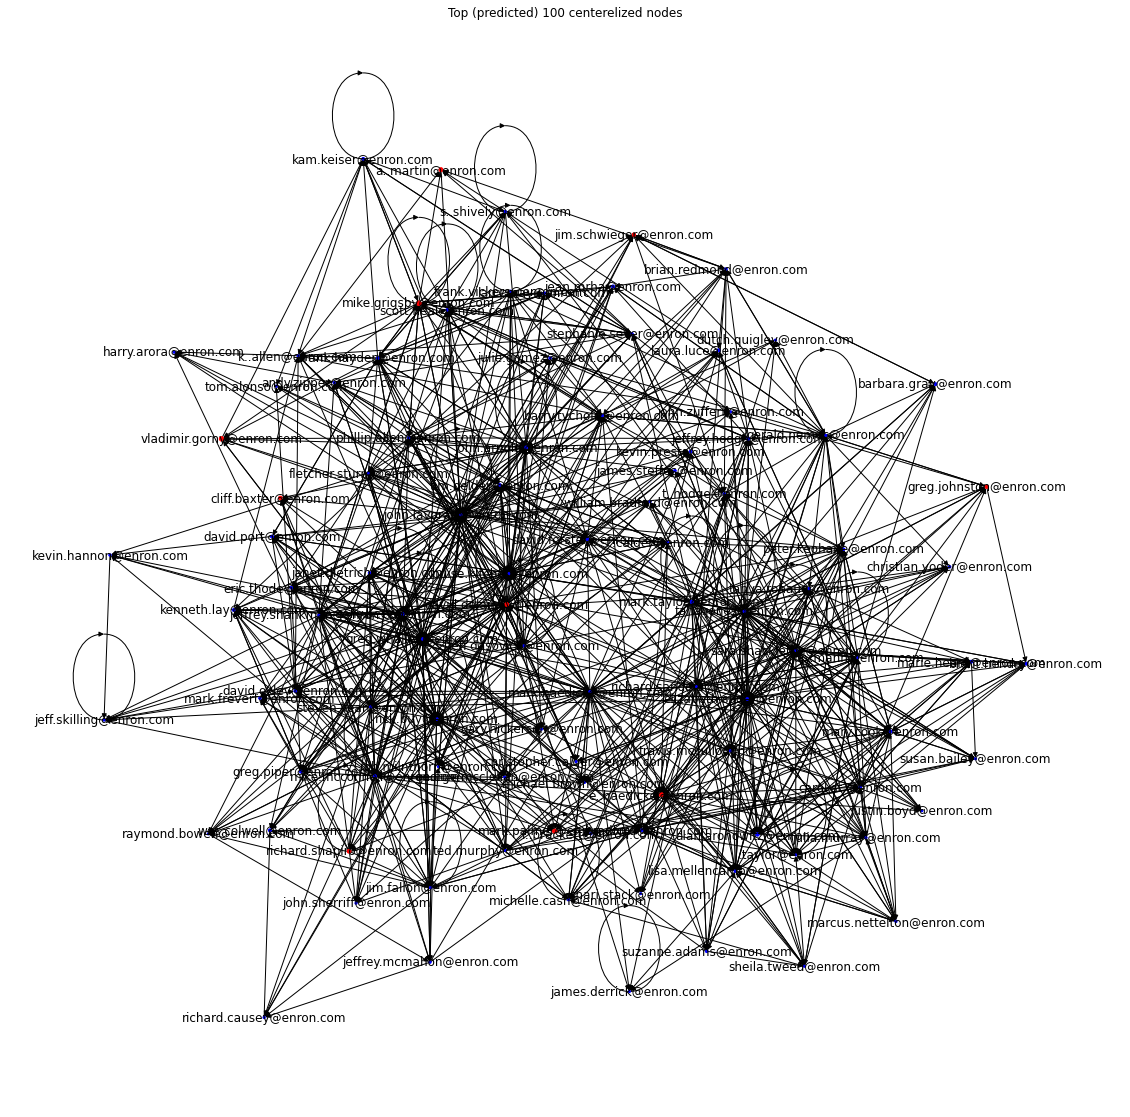

In [13]:
top_k_to_plot_amount = 100

predicted_top_k_nodes_names = [node_name for node_name, node_score in nodes_centrality_scores_sorted][:top_k_to_plot_amount]
predicted_top_k_nodes_scores = np.array([node_score for node_name, node_score in nodes_centrality_scores_sorted][:top_k_to_plot_amount])
predicted_top_k_nodes_scores = ((predicted_top_k_nodes_scores/predicted_top_k_nodes_scores.max())*20).tolist()

enron_email_sub_graph = enron_email_graph.subgraph(predicted_top_k_nodes_names)


node_colors = []
all_top_ten_emails = [x[0] for x in top_10_nodes]
for name in predicted_top_k_nodes_names:
    if name in all_top_ten_emails:
      node_colors.append('red') 
    else:
      node_colors.append('blue')

plt.figure(figsize=(20,20))
plt.title(f'Top (predicted) {top_k_to_plot_amount} centerelized nodes')
# top 10 will appear in red, each node size is according to its centrality score
ntkx.drawing.nx_pylab.draw_kamada_kawai(enron_email_sub_graph, with_labels=True, node_size=predicted_top_k_nodes_scores, node_color=node_colors)

In [ ]:
ntkx.drawing.nx_pylab.draw_kamada_kawai(enron_email_graph, with_labels=False, node_size=centrality_scores, node_color=node_colors)